### Importing the necessary modules in python
1. Python wrapper for Reddit API (Praw) 
2. Pandas
3. Seaborn
4. nltk
5. wordcloud
6. matlplotlib
7. sklearn
8. pickle

In [1]:
import praw
import pandas as pd
import seaborn as sb
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from wordcloud import WordCloud,ImageColorGenerator
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
import pickle
from sklearn.linear_model import LogisticRegression as LR
from sklearn.ensemble import RandomForestClassifier as RFC

# Part I - Reddit Data Collection

### Connection establishment and access
1. Connecting to reddit using praw.Reddit() function
2. Accessing the "india" subreddit using reddit.subreddit() function

In [2]:
reddit = praw.Reddit(client_id='dxCAxrQivxyfDw',\
                    client_secret='GjWF0Jl0OK6-A5ihiqSAOF0xrLQ',\
                    user_agent='Reddit Flare Detection',\
                    username='vaibhavsarda',\
                    password='Ganesh@108')

subreddit = reddit.subreddit('india')  

### Reddit Data Collection
1. First we make a list of all possible flairs on "india" subreddit
2. Next, for every flair, we search for 50 posts of that flair.
3. For each of the posts, we collect some important data like title, number of comments, author, etc.
4. For every post, we also collect data of top level comments of that post.

In [3]:
flairs = ["Scheduled","Politics","Photography","Police/Economy","AskIndia","Sports",
          "Non-Political","Science/Technology","Food","Business/Finance","Coronavirus","Unverified"]

# flare, title, score, id, subreddit, url, num_comments, selftext, created, body, author, comments
# flare, title, score, id, url, num_comments, created, selftext, author, comments
data = []

for f in flairs:
    
    flair_posts = subreddit.search(f,limit=50)
    
    ctr=0
    
    for post in flair_posts:
           
        data.append([f,post.title,post.score,post.id,post.url,post.num_comments,post.created,post.selftext,post.author])
    
        post.comments.replace_more(limit=0)
        
        all_comments=""
        
        # tlc: top level comments
        for tlc in post.comments:
            all_comments=all_comments+" "+tlc.body
        
        data[-1].append(all_comments)
        
        ctr+=1
        
        print("PROGRESS: "+str(f)+":",ctr)

Creating a Data Frame of the data collected from Reddit

In [ ]:
data=pd.DataFrame(data,columns=['flare','title','score','id','url','num_comments','created','selftext','author','comments'])
print(data)

# Part II - Exploratory Data Analysis (EDA)

1. Data has 600 rows and 10 columns
2. Following is the information about data types of data columns (obtained using data.info() function)

In [4]:
# data.to_csv("Reddit_Data_limit_50.csv",index=False)

data=pd.read_csv("Reddit_Data_limit_50.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 10 columns):
flare           600 non-null object
title           600 non-null object
score           600 non-null int64
id              600 non-null object
url             600 non-null object
num_comments    600 non-null int64
created         600 non-null float64
selftext        325 non-null object
author          600 non-null object
comments        547 non-null object
dtypes: float64(1), int64(2), object(7)
memory usage: 47.0+ KB


Following is the information about columns with integer and float values: score, num_comments and created (obtained using data.describe() function)

### OBSERVATIONS
1. The difference between the min and max score is of the order of 104. This indicates the large range of possible score values. Also, the large standard deviation indicates the large variability of score values, i.e., the data points are spread over a large range of values.  
2. The range of values of the number of comments is also large. Standard deviation of number of comments Is lower than the standard deviation of score, which indicates lower variability of number of comments as compared to score values.
3. The difference between the 75 percentile value and max value is large for both num_comments and score columns. This indicates the presence of outliers in the data.


In [5]:
data.describe()

,score,num_comments,created
count,600.000000,600.000000,6.000000e+02
mean,199.386667,56.135000,1.551376e+09
std,1002.625678,354.928971,5.317285e+07
min,0.000000,0.000000,1.306251e+09
25%,10.000000,3.000000,1.547655e+09
50%,28.000000,10.000000,1.576129e+09
75%,122.000000,32.000000,1.584338e+09
max,17796.000000,6924.000000,1.586489e+09


### Preprocessing text data

Preprocessing the title, selftext and comments columns
    
##### TOKENIZATION
Used RegexpTokenizer with argument r’\w+’. This removes punctuation marks from the text and separates the text into a list of words. Used nltk.tokenize for performing this task.

##### STOP WORD REMOVAL
Removed English stop words from the text. This consists of common English words like “and”, “is”, “the”, which do not contribute much significantly to the overall sentiment of the content. Used nltk.corpus for this task.

##### LEMMATIZATION
Used lemmatization, which is grouping together different forms of the same word so that all these words can be analysed as a single item. Example: “play”, “playing”, “played” all these words are analysed as “play”. Used WordNetLemmatizer from nltk.stem for performing this task.

##### CONVERSION OF WORDS TO LOWER CASE
Converted all the words to lower case using lower() function in Python. This is because the difference in case of the same word would not affect the overall meaning significantly, for most of the cases.

In [5]:
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('wordnet')

def preprocess_text(s):
    
    if(type(s)==float):
        return "NaN"
    
    stop_words=set(stopwords.words('english'))
    tokenizer=RegexpTokenizer(r'\w+')
    lem=WordNetLemmatizer()
  
    word_tokens=tokenizer.tokenize(s)
    pp_content=""

    for g in word_tokens:

        if(g not in stop_words):
            pp_content=pp_content+lem.lemmatize(g.lower())+" "
    
    return pp_content


# pp refers to preprocessed 
data['pp_title']=data['title'].apply(preprocess_text)
data['pp_selftext']=data['selftext'].apply(preprocess_text)
data['pp_comments']=data['comments'].apply(preprocess_text)

### Most Common Words in comments

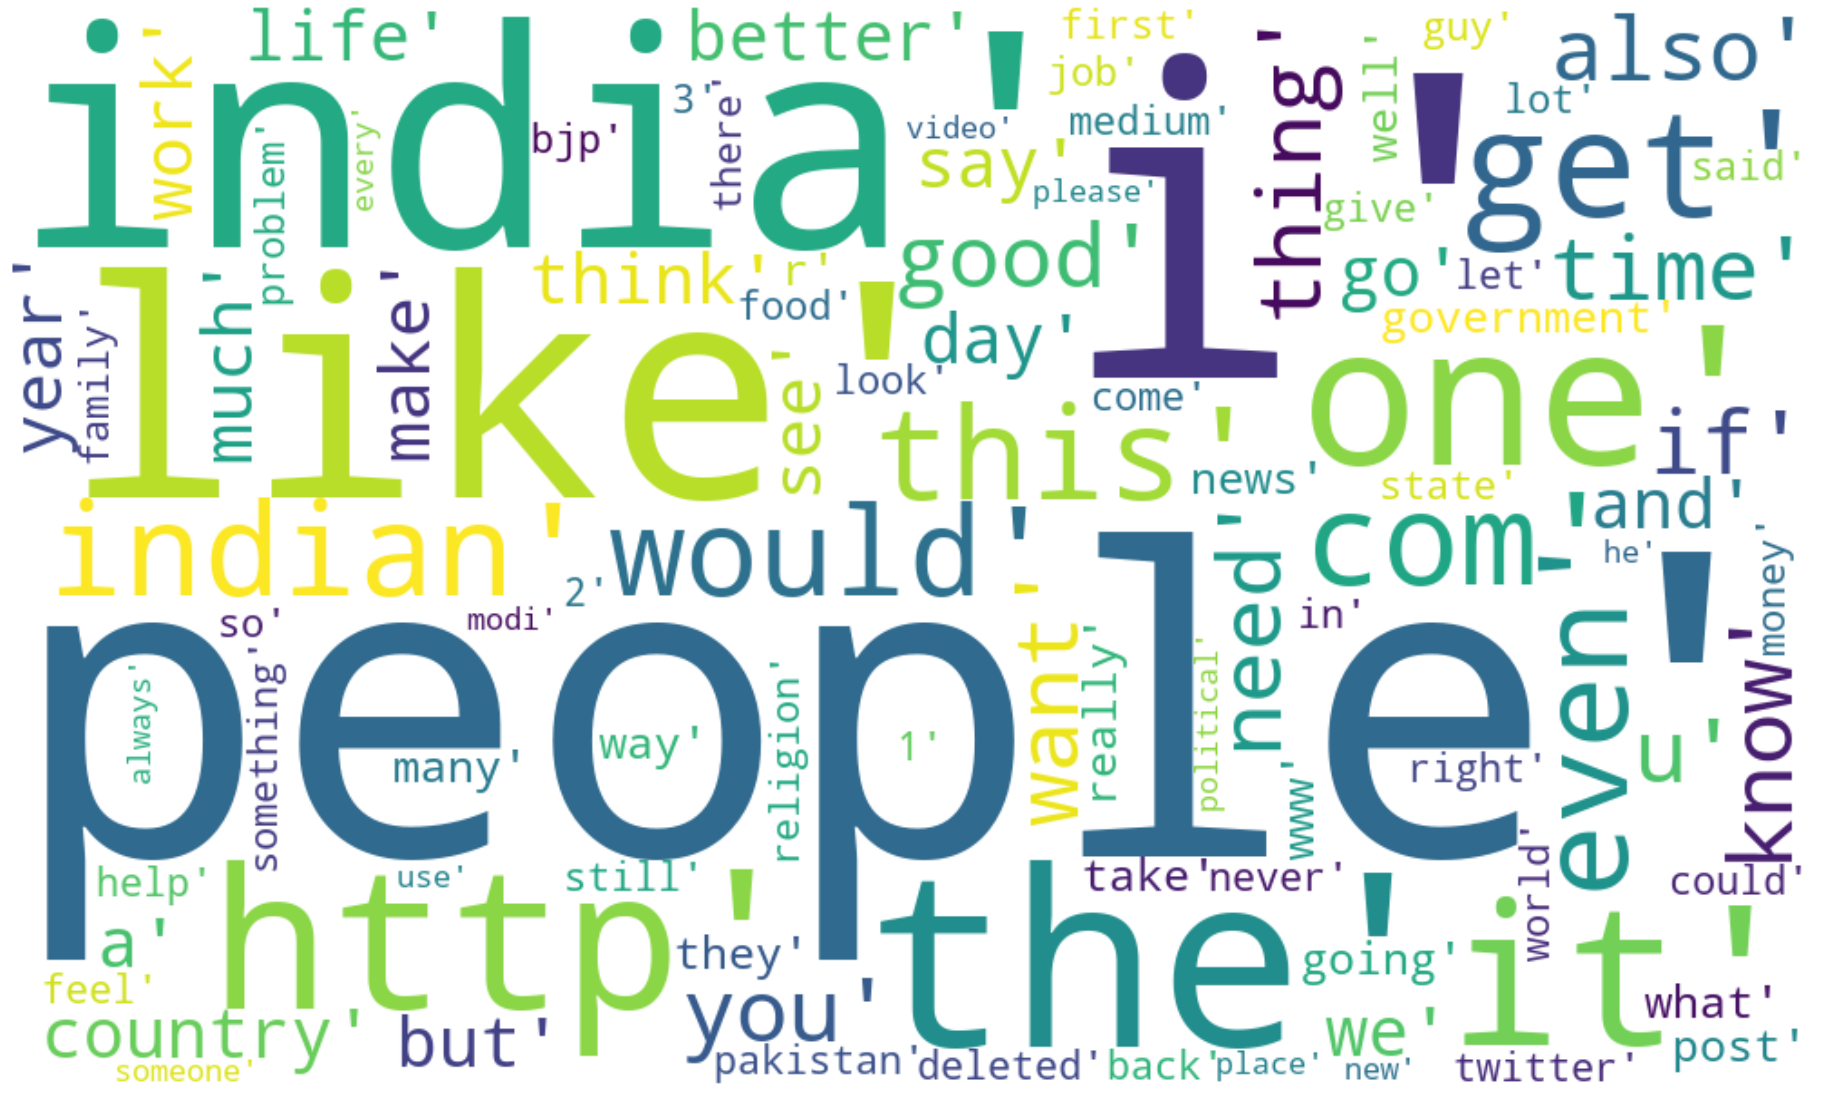

In [16]:
pp_comm_col = data['pp_comments']

words_arr=[]
for row in pp_comm_col:
    tmp=row.split(" ")
    for g in tmp:
        words_arr.append(g)

common=FreqDist(words_arr).most_common(100)

wc=WordCloud(width=1000,height=600,background_color='white').generate(str(common))
figure=plt.figure(figsize=(40,20),facecolor='white')
plt.imshow(wc,interpolation='bilinear')
plt.axis('off')
plt.show()

### Frequency of 15 most common words
1. The word "i" is used most frequently than all other words.
2. It is followed by words "people" and "india" which are 2nd and 3rd most popularly used words, respectively, in comments.

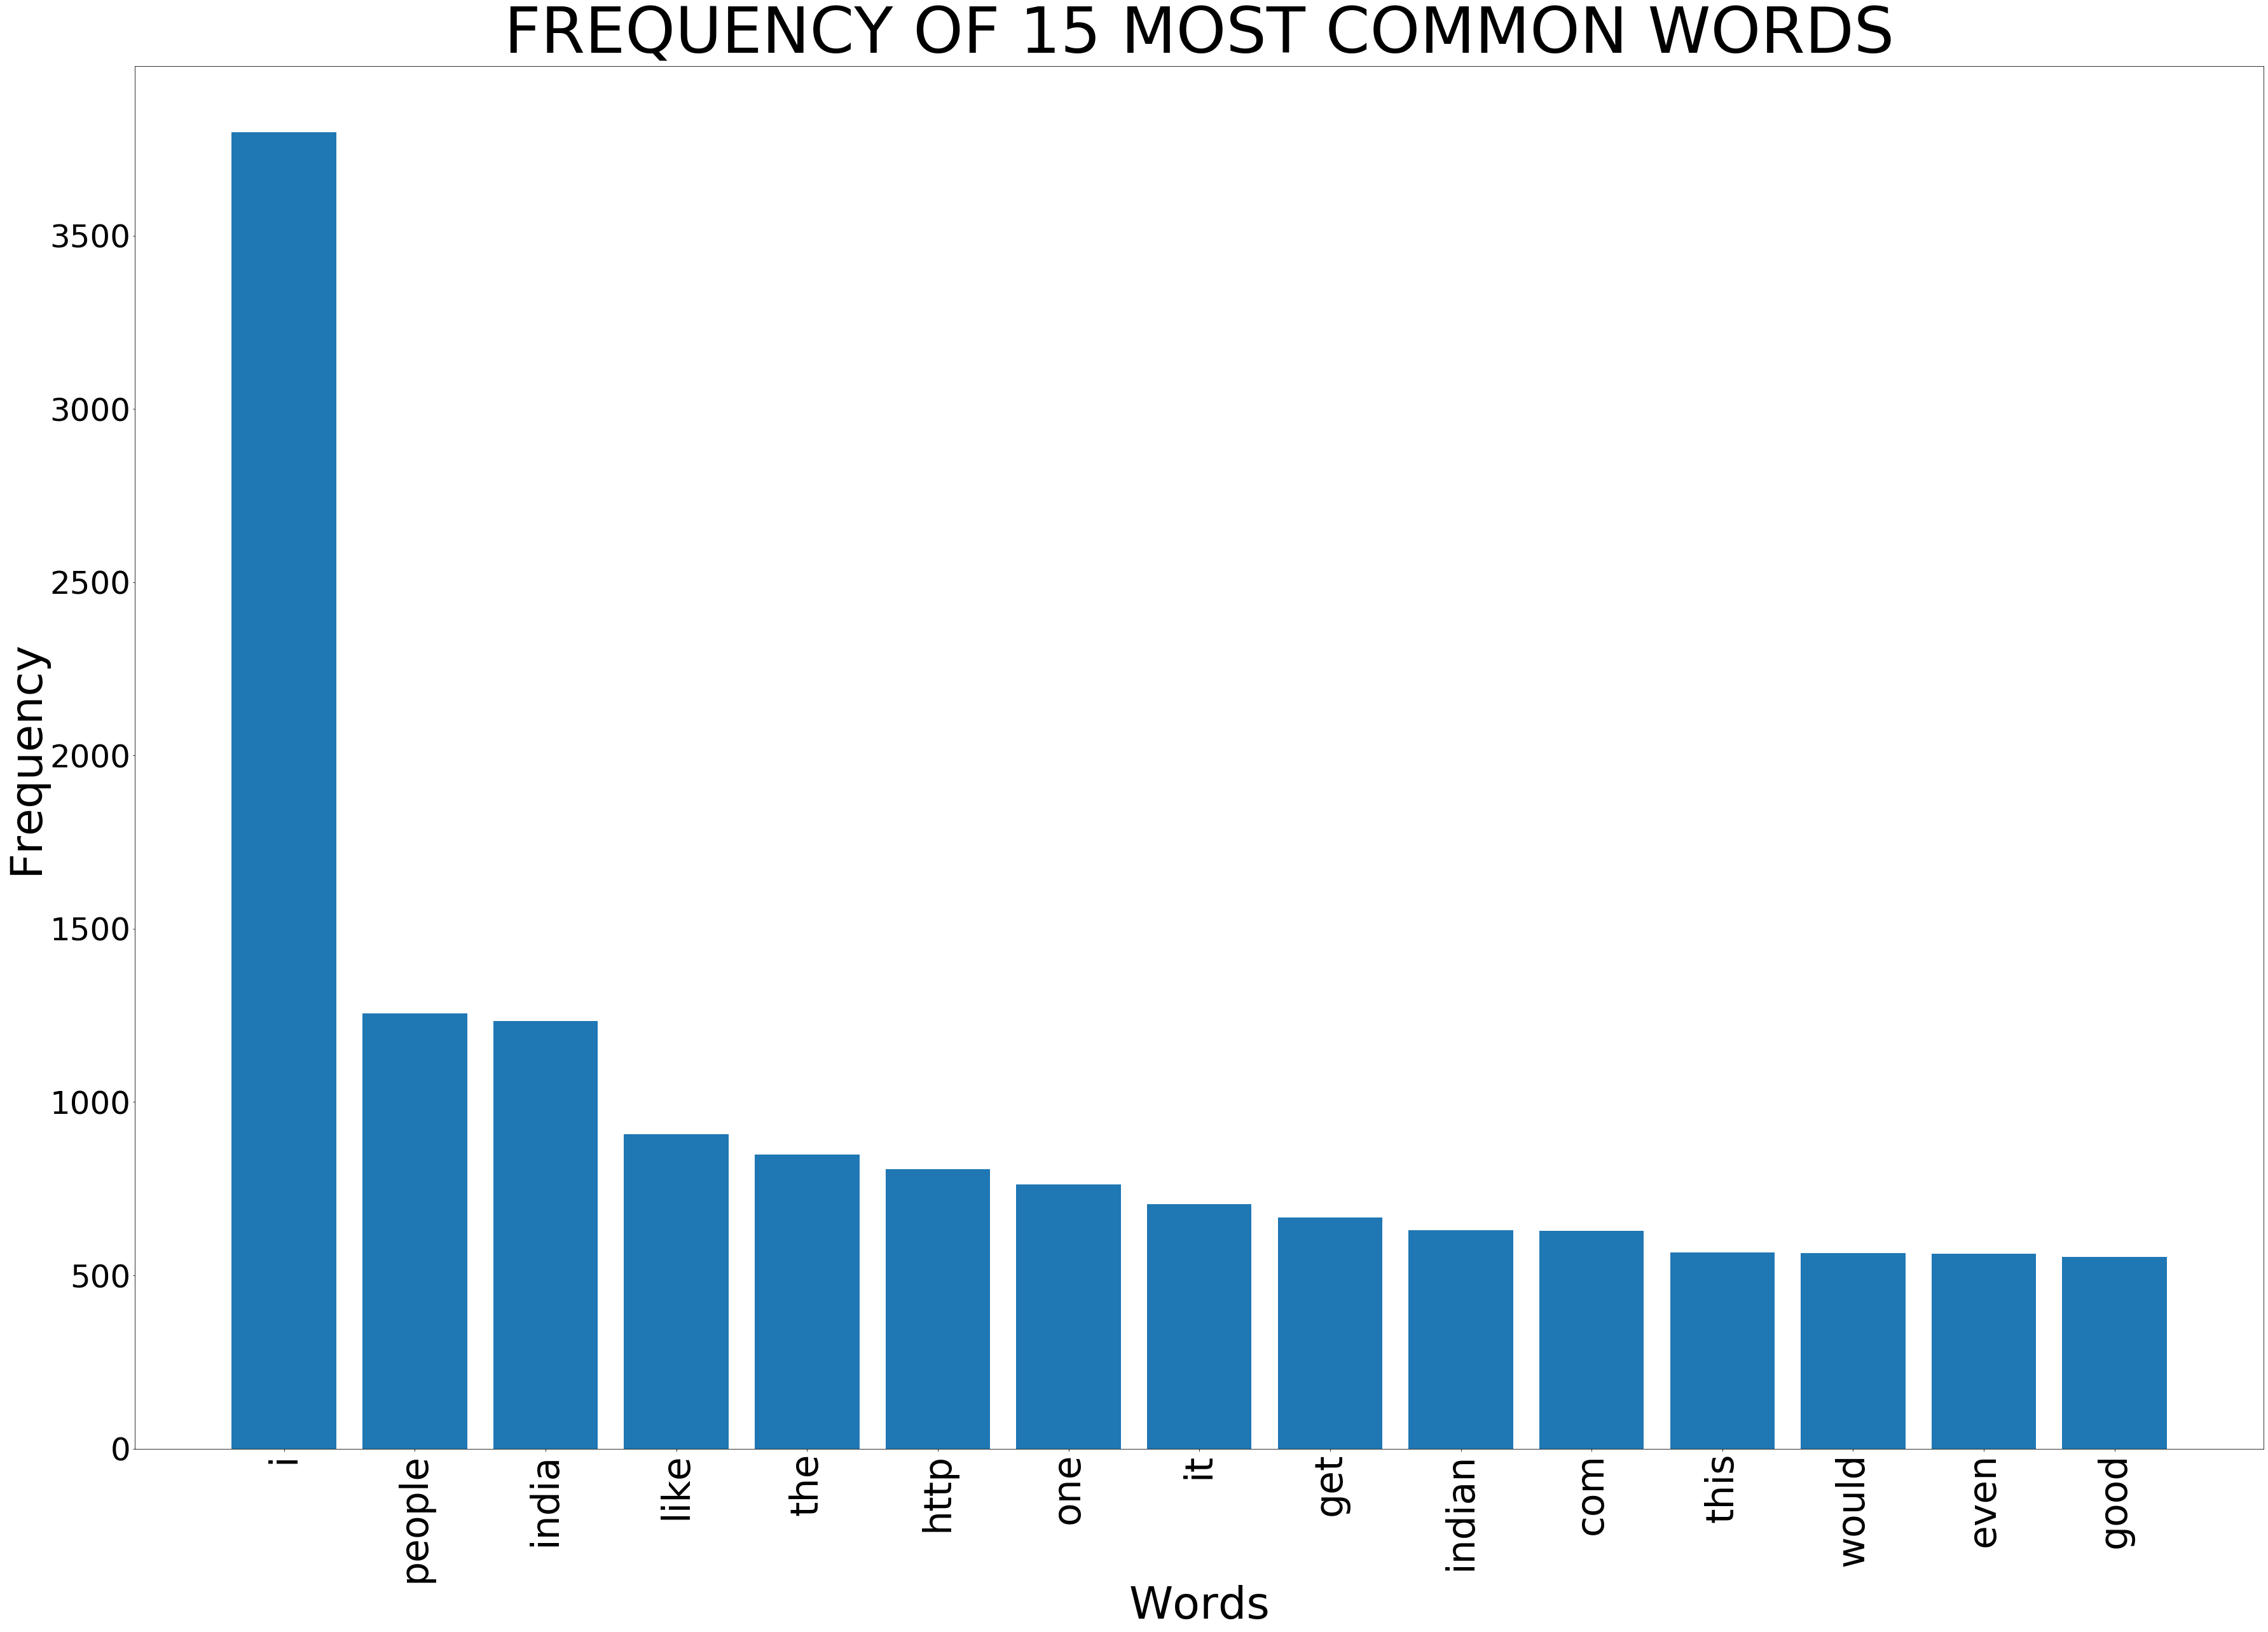

In [26]:
graph_common=FreqDist(words_arr).most_common(15)
a,b=zip(*graph_common)

plt.figure(figsize=(60,40))
plt.bar(a,b)
plt.xlabel('Words',fontsize=70)
plt.xticks(rotation=90,fontsize=60)
plt.ylabel('Frequency',fontsize=70)
plt.yticks(fontsize=50)
plt.title('FREQUENCY OF 15 MOST COMMON WORDS',fontsize=100)
plt.show()

### Relationship of flares with scores
1. For AskIndia, Business/Finance and Photography, most of the posts have scores less than 50.
2. Almost all flares have some number of posts with scores between 50 to 100. For Photography, there is only one such post.
3. For Food and Politics, almost half of the posts (50% posts) have score greater than 100. For Non-Political and Scheduled, a large percentage of posts (38% and 34% posts respectively) have score greater than 100.  

In [34]:
def count_scores(scores):
    count=0
    for score in scores:
        if(score>=50 and score<100):
            count+=1
    return count
            
print("####################################")
print(data.groupby('flare')['score'].apply(lambda x: (x<50).sum()).reset_index(name='LESS THAN 50'))
print("####################################")
print(data.groupby('flare')['score'].apply(lambda x: (count_scores(x))).reset_index(name='B/W 50 AND 100'))
print("####################################")
print(data.groupby('flare')['score'].apply(lambda x: (x>=100).sum()).reset_index(name='MORE THAN 100'))
print("####################################")

# data.groupby('flare')['num_comments'].max()

####################################
                 flare  LESS THAN 50
0             AskIndia            41
1     Business/Finance            38
2          Coronavirus            28
3                 Food            16
4        Non-Political            27
5          Photography            44
6       Police/Economy            25
7             Politics            17
8            Scheduled            29
9   Science/Technology            34
10              Sports            28
11          Unverified            33
####################################
                 flare  B/W 50 AND 100
0             AskIndia               7
1     Business/Finance               5
2          Coronavirus               8
3                 Food               9
4        Non-Political               4
5          Photography               1
6       Police/Economy               9
7             Politics               6
8            Scheduled               4
9   Science/Technology               6
10              

# Part III - Building a Flare Detector
Performing Feature Extraction by doing TfIdf_Vectorization.

In [6]:
def TfIdf_Vectorization(combined_data):
    
    vectorizer=TfidfVectorizer(max_features=100)
    X=vectorizer.fit_transform(combined_data)
#     pickle.dump(vectorizer,open('vect_object.pickle','wb'))
    return X
    
all_data = data['pp_title']+data['pp_comments']
data = data.assign(combined_data=all_data)

X = TfIdf_Vectorization(data['combined_data'])
Y = data['flare']

### Train-Test Split

In [7]:
X_train, X_test, Y_train, Y_test = train_test_split(X,Y,test_size=0.3,random_state=42)

In [8]:
def Multi_Layer_Perceptron(X_train,Y_train,X_test,Y_test):
    
    multi_layer_perceptron = MLPClassifier(hidden_layer_sizes=(20,20,),max_iter=2000)
    multi_layer_perceptron.fit(X_train,Y_train)
    Y_pred_train = multi_layer_perceptron.predict(X_train)
    Y_pred_test = multi_layer_perceptron.predict(X_test)

    print("Accuracy on Training Set:",accuracy_score(Y_pred_train,Y_train))
    print("Accuracy on Testing Set:",accuracy_score(Y_pred_test,Y_test))
    
    return multi_layer_perceptron

mlp_model=Multi_Layer_Perceptron(X_train,Y_train,X_test,Y_test)

Accuracy on Training Set: 0.9547619047619048
Accuracy on Testing Set: 0.3


### Naive Bayes Classifier

In [ ]:
def Naive_Bayes_Classifier(X_train,Y_train,X_test,Y_test):
    
    naive_bayes = MultinomialNB()
    naive_bayes.fit(X_train,Y_train)
    Y_pred_train = naive_bayes.predict(X_train)
    Y_pred_test = naive_bayes.predict(X_test)
    
    print("Accuracy on Training Set:",accuracy_score(Y_pred_train,Y_train))
    print("Accuracy on Testing Set:",accuracy_score(Y_pred_test,Y_test))
    
    return naive_bayes

nb_model=Naive_Bayes_Classifier(X_train,Y_train,X_test,Y_test)

### Support Vector Machine

In [11]:
def Support_Vector_Machine(X_train,Y_train,X_test,Y_test):
    svm=SVC(tol=1e-4,gamma='scale')
    svm.fit(X_train,Y_train)
    
    Y_pred_train = svm.predict(X_train)
    Y_pred_test = svm.predict(X_test)

    print("Accuracy on Training Set:",accuracy_score(Y_pred_train,Y_train))
    print("Accuracy on Testing Set:",accuracy_score(Y_pred_test,Y_test))
    
    return svm

svm_model=Support_Vector_Machine(X_train,Y_train,X_test,Y_test)

Accuracy on Training Set: 0.8952380952380953
Accuracy on Testing Set: 0.32222222222222224


### Logistic Regression

In [12]:
def Logistic_Reg(X_train,Y_train,X_test,Y_test):
    
    logistic_regression = LR()
    logistic_regression.fit(X_train,Y_train)
    Y_pred_train = logistic_regression.predict(X_train)
    Y_pred_test = logistic_regression.predict(X_test)

    print("Accuracy on Training Set:",accuracy_score(Y_pred_train,Y_train))
    print("Accuracy on Testing Set:",accuracy_score(Y_pred_test,Y_test))
    
    return logistic_regression

lr_model=Logistic_Reg(X_train,Y_train,X_test,Y_test)

Accuracy on Training Set: 0.6428571428571429
Accuracy on Testing Set: 0.32222222222222224


c:\users\vaibhav\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
c:\users\vaibhav\appdata\local\programs\python\python36\lib\site-packages\sklearn\linear_model\logistic.py:469: FutureWarning: Default multi_class will be changed to 'auto' in 0.22. Specify the multi_class option to silence this warning.
  "this warning.", FutureWarning)


### Analysis of performance of classifier
1. Using random forest classifier gives the best accuracy on the test set (37.22 %)
2. From the confusian matrix, we can observe that the highest number of correct classifications are for Food, followed by Photography and Politics flairs. Hence, the classifier is good at predicting these flairs correctly.
3. The lowest number of correct classifications are for Science/Technology. Hence, the classifier is not good at predicting this flair correctly. 

In [13]:
def Random_Forest(X_train,Y_train,X_test,Y_test):
    
    random_forest = RFC(n_estimators=1000, random_state=42)
    random_forest.fit(X_train,Y_train)
    Y_pred_train = random_forest.predict(X_train)
    Y_pred_test = random_forest.predict(X_test)
    
    classes=random_forest.classes_
    for e in range(len(classes)):
        print(e,":",classes[e])
        
    print("Confusion Matrix for Test Set:")
    print(confusion_matrix(Y_test,Y_pred_test))
    
    print("Accuracy on Training Set:",accuracy_score(Y_pred_train,Y_train))
    print("Accuracy on Testing Set:",accuracy_score(Y_pred_test,Y_test))
    
    return random_forest

random_forest=Random_Forest(X_train,Y_train,X_test,Y_test)

0 : AskIndia
1 : Business/Finance
2 : Coronavirus
3 : Food
4 : Non-Political
5 : Photography
6 : Police/Economy
7 : Politics
8 : Scheduled
9 : Science/Technology
10 : Sports
11 : Unverified
Confusion Matrix for Test Set:
[[ 4  5  0  0  0  2  1  0  0  1  0  1]
 [ 0  4  1  0  0  1  0  2  0  1  0  0]
 [ 1  2  2  0  0  0  5  0  1  0  3  0]
 [ 0  0  0 14  0  0  0  0  0  0  0  2]
 [ 0  0  0  0  9  0  0  1  0  0  0  0]
 [ 0  2  0  0  0 12  1  0  0  0  0  0]
 [ 0  5  0  0  2  0  3  2  0  2  1  1]
 [ 0  5  1  0  4  1  0 10  1  0  1  0]
 [ 3  3  0  0  0  2  1  2  2  1  1  0]
 [ 2  1  0  0  4  3  0  1  2  1  0  0]
 [ 0  4  2  0  0  0  2  0  3  1  2  1]
 [ 0  3  2  2  0  5  0  1  1  1  0  4]]
Accuracy on Training Set: 0.9571428571428572
Accuracy on Testing Set: 0.37222222222222223
